In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Math, Latex
from matplotlib import pyplot as plt
import re
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import random

# Глобальная фиксация для всех библиотек
SEED = 322
random.seed(SEED)
np.random.seed(SEED)

def calculate_iou(lower_true, upper_true, lower_pred, upper_pred, epsilon=1e-6):
    intersection = np.maximum(0, np.minimum(upper_true, upper_pred) - np.maximum(lower_true, lower_pred))
    union = (upper_true - lower_true + epsilon) + (upper_pred - lower_pred + epsilon) - intersection
    return np.mean(intersection / union)

# 1. ЗАГРУЗКА
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = train[train['price_p05'] > 0]
train['dt'] = pd.to_datetime(train['dt'])
test['dt'] = pd.to_datetime(test['dt'])

# 2. FEATURE ENGINEERING
def create_smart_features(df, train_ref=None):
    if train_ref is not None:
        prod_price_map = train_ref.groupby('product_id')['price_p05'].mean().to_dict()
        df['global_prod_avg'] = df['product_id'].map(prod_price_map)
        cat_price_map = train_ref.groupby('third_category_id')['price_p05'].mean().to_dict()
        df['global_cat_avg'] = df['third_category_id'].map(cat_price_map)
    
    cat_stores_map = df.groupby('third_category_id')['n_stores'].transform('mean')
    df['store_density_ratio'] = df['n_stores'] / (cat_stores_map + 1e-6)
    df['temp_hum_index'] = df['avg_temperature'] * (df['avg_humidity'] / 100)
    df['category_breadth'] = df.groupby(['dt', 'third_category_id'])['product_id'].transform('nunique')
    return df

train = create_smart_features(train, train_ref=train)
test = create_smart_features(test, train_ref=train)

# 3. ЦИКЛИЧЕСКИЕ ПРИЗНАКИ
def add_cyclical_features(df):
    df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train = add_cyclical_features(train)
test = add_cyclical_features(test)

# 4. СПИСОК ПРИЗНАКОВ
cat_features = ['management_group_id', 'first_category_id', 'activity_flag']
features = [
    'n_stores', 'precpt', 'avg_temperature', 'avg_humidity', 
    'avg_wind_level', 'week_of_year', 'month_sin', 'month_cos',
    'global_prod_avg', 'global_cat_avg', 'store_density_ratio',
    'temp_hum_index', 'category_breadth'
] + cat_features

train[features] = train[features].fillna(train[features].mean(numeric_only=True))
test[features] = test[features].fillna(train[features].mean(numeric_only=True))

# 5. ВАЛИДАЦИЯ / КАЛИБРОВКА
train_parts, val_parts = [], []
for _, group in train.groupby('dt'):
    group = group.sample(frac=1, random_state=SEED).reset_index(drop=True)
    split_idx = int(len(group) * 0.8)
    train_parts.append(group.iloc[:split_idx])
    val_parts.append(group.iloc[split_idx:])

train_part = pd.concat(train_parts)
val_part = pd.concat(val_parts)

# ПАРАМЕТРЫ CatBoost (Optuna)
best_optuna_params = {
    'learning_rate': 0.09981859399773757, 
    'depth': 7, 
    'l2_leaf_reg': 8.533654459953857, 
    'random_strength': 1.3535330397123693, 
    'bagging_temperature': 0.757231412091197
}

cb_params = {
    'iterations': 3000,
    'random_seed': SEED,
    'verbose': 100,
    'early_stopping_rounds': 500,
    **best_optuna_params
}

# Обучение на частях для калибровки
print("Обучение моделей для расчета калибровки...")
model_low = CatBoostRegressor(loss_function='MAE', **cb_params)
model_high = CatBoostRegressor(loss_function='MAE', **cb_params)

model_low.fit(train_part[features], train_part['price_p05'], 
              eval_set=(val_part[features], val_part['price_p05']), 
              cat_features=cat_features, use_best_model=True)

model_high.fit(train_part[features], train_part['price_p95'], 
               eval_set=(val_part[features], val_part['price_p95']), 
               cat_features=cat_features, use_best_model=True)

# --- ИЗМЕНЕННЫЙ БЛОК: РАЗДЕЛЬНЫЙ ПОИСК ALPHA ---
print("\nПоиск оптимальных раздельных alpha на валидации...")
calib_preds_low = model_low.predict(val_part[features])
calib_preds_high = model_high.predict(val_part[features])

nonconf_low = calib_preds_low - val_part['price_p05']
nonconf_high = val_part['price_p95'] - calib_preds_high

best_iou = -1
best_alphas = (0.1, 0.1)
best_q = (0, 0)

# Генерируем сетку с шагом 0.01
alphas_to_test = np.linspace(0.1, 0.9, 81)

for al in alphas_to_test:
    # Оптимизация: ql зависит только от al
    ql = np.quantile(nonconf_low, 1 - al/2)
    p05_corr = calib_preds_low - ql
    
    for ah in alphas_to_test:
        qh = np.quantile(nonconf_high, 1 - ah/2)
        p95_corr = calib_preds_high + qh
        
        # Гарантируем корректность интервала
        p95_corr_safe = np.maximum(p95_corr, p05_corr + 0.001)
        
        current_iou = calculate_iou(
            val_part['price_p05'].values, 
            val_part['price_p95'].values, 
            p05_corr, 
            p95_corr_safe
        )
        
        if current_iou > best_iou:
            best_iou = current_iou
            best_alphas = (al, ah)
            best_q = (ql, qh)

q_low, q_high = best_q
print(f"Лучшие Alpha: Low={best_alphas[0]:.3f}, High={best_alphas[1]:.3f}")
print(f"Лучший IoU на валидации: {best_iou:.4f}")
print(f"Поправки: q_low = {q_low:.4f}, q_high = {q_high:.4f}\n")

# 6. ФИНАЛЬНОЕ ОБУЧЕНИЕ
print("Обучение финальных моделей на полном датасете...")
final_params_low = cb_params.copy()
final_params_low['iterations'] = model_low.get_best_iteration() + 1
final_params_low.pop('early_stopping_rounds', None)

final_params_high = cb_params.copy()
final_params_high['iterations'] = model_high.get_best_iteration() + 1
final_params_high.pop('early_stopping_rounds', None)

final_low = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_low)
final_high = CatBoostRegressor(loss_function='MAE', allow_writing_files=False, **final_params_high)

final_low.fit(train[features], train['price_p05'], cat_features=cat_features, verbose=100)
final_high.fit(train[features], train['price_p95'], cat_features=cat_features, verbose=100)

# 7. ПРЕДСКАЗАНИЕ С РАЗДЕЛЬНЫМИ Q
print("Создание предсказаний...")
final_test_low = final_low.predict(test[features])
final_test_high = final_high.predict(test[features])

test['price_p05'] = final_test_low - q_low
test['price_p95'] = final_test_high + q_high

# Финальная страховка
test['price_p95'] = np.maximum(test['price_p95'], test['price_p05'] + 0.001)

submission = test[['row_id', 'price_p05', 'price_p95']].sort_values('row_id')
submission.to_csv('submission_split_conformal.csv', index=False)
print("Готово! Использован раздельный подбор Alpha.")

Обучение моделей для расчета калибровки...
0:	learn: 0.1428280	test: 0.1346232	best: 0.1346232 (0)	total: 86.1ms	remaining: 4m 18s
100:	learn: 0.0860270	test: 0.0921969	best: 0.0921843 (94)	total: 2.79s	remaining: 1m 19s
200:	learn: 0.0812801	test: 0.0923276	best: 0.0919774 (140)	total: 5.27s	remaining: 1m 13s
300:	learn: 0.0785447	test: 0.0929835	best: 0.0919774 (140)	total: 7.83s	remaining: 1m 10s
400:	learn: 0.0765017	test: 0.0934613	best: 0.0919774 (140)	total: 10.5s	remaining: 1m 7s
500:	learn: 0.0748138	test: 0.0938462	best: 0.0919774 (140)	total: 12.9s	remaining: 1m 4s
600:	learn: 0.0734555	test: 0.0939195	best: 0.0919774 (140)	total: 15.3s	remaining: 1m 1s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.09197735328
bestIteration = 140

Shrink model to first 141 iterations.
0:	learn: 0.0986558	test: 0.0928609	best: 0.0928609 (0)	total: 23.8ms	remaining: 1m 11s
100:	learn: 0.0811582	test: 0.0884697	best: 0.0878753 (37)	total: 2.4s	remaining: 1m 8s
200:	learn:

In [2]:
# идеи - признаки через стандартные отклонения и т д в разных разрезах?
# анализ текущих ошибок модели на валидации
# замена валидации на OOT ?
# обучение нейросети + conformal + кастомный лосс Pinball + coverage penalty для нейросети 

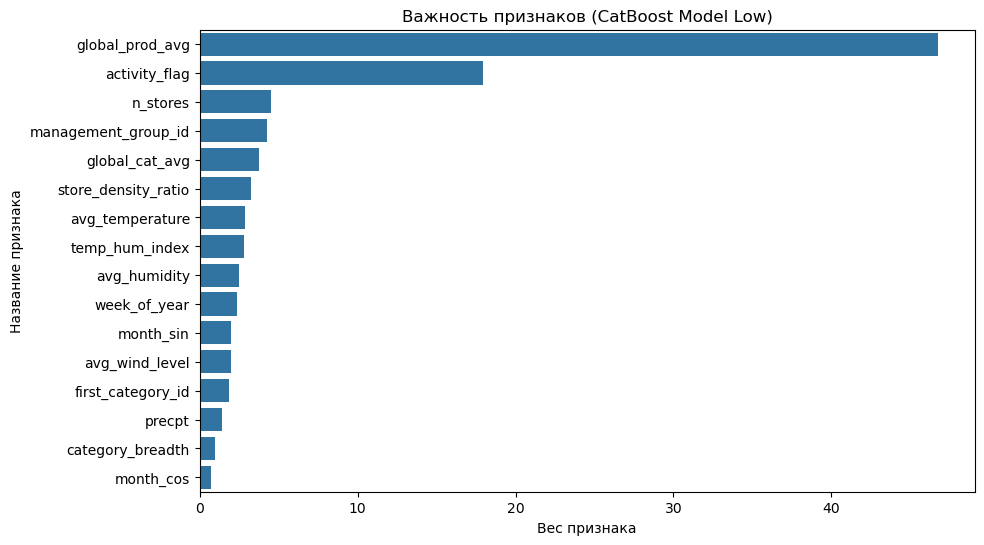

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Получаем данные
feature_importance = final_low.get_feature_importance(prettified=True)

# Строим график
plt.figure(figsize=(10, 6))
sns.barplot(x="Importances", y="Feature Id", data=feature_importance)
plt.title('Важность признаков (CatBoost Model Low)')
plt.xlabel('Вес признака')
plt.ylabel('Название признака')
plt.show()

In [4]:
train.columns

Index(['dt', 'price_p05', 'price_p95', 'n_stores', 'precpt', 'avg_temperature',
       'avg_humidity', 'avg_wind_level', 'holiday_flag', 'activity_flag',
       'management_group_id', 'first_category_id', 'second_category_id',
       'third_category_id', 'dow', 'day_of_month', 'week_of_year', 'month',
       'product_id', 'global_prod_avg', 'global_cat_avg',
       'store_density_ratio', 'temp_hum_index', 'category_breadth', 'dow_sin',
       'dow_cos', 'month_sin', 'month_cos'],
      dtype='object')